<a href="https://colab.research.google.com/github/rzunick/MNA-Proyecto-Integrador-Equipo-43/blob/main/Dominant_Color_Detection_Model_Profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 - Introduction

Through this notebook, model profiling using PyTorch is performed on the trained models for a Dominant Color Detection CNN Model.

#2 - Importing Dependencies, Dataset, and Models

In [1]:
import torch
import torch.nn as nn
import os
import  numpy as np
import pandas as pd
from torch.utils.data import  Dataset, DataLoader
from  PIL import  Image
from  torchvision.transforms import  ToTensor, Compose, Resize, CenterCrop, Normalize
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import  glob
import requests
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
import shutil
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F

!pip install opencv-python-headless
from torchsummary import summary

from PIL import Image
import cv2
from collections import Counter

from  tqdm import tqdm
from sklearn.metrics import accuracy_score

from  collections import  defaultdict
import json

import time
import random

In [2]:
# URL of the .zip file in the GitHub repository
github_zip_url = "https://github.com/rzunick/MNA-Proyecto-Integrador-Equipo-43/raw/main/cifar_10_color_v4_balanced.zip?download="

# Path to save the downloaded .zip file
zip_file_path = '/content/cifar_10_color_v4.zip'

# Download the .zip file from GitHub
response = requests.get(github_zip_url)
with open(zip_file_path, 'wb') as f:
    f.write(response.content)

# Verify the download
if response.status_code == 200:
    print("File downloaded successfully")
else:
    print("Failed to download file")

File downloaded successfully


In [3]:
#Specify zip file path
zip_file_path = '/content/cifar_10_color_v4.zip'

In [4]:
# Confirmar tipo de archivo es tipo .zip
!file /content/cifar_10_color.zip

/content/cifar_10_color.zip: cannot open `/content/cifar_10_color.zip' (No such file or directory)


In [5]:
from zipfile import ZipFile

# Specify the directory where you want to extract the files
extract_to_directory = '/content'

# Create a ZipFile object
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)

In [6]:
# Dataset Path
path = '/content/cifar_10_color_v4'

Label counts: Counter({2: 1600, 6: 1600, 0: 1600, 3: 1600, 4: 1600, 1: 1600, 5: 1600, 7: 1600})


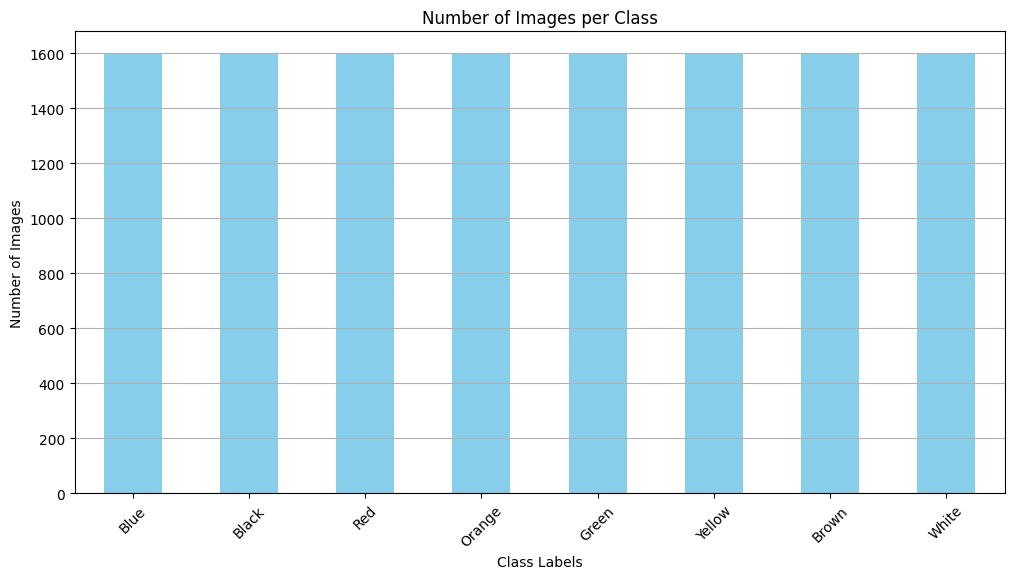

In [7]:
# Configuration 4: 8 labels
labels = ["Red","Yellow","Blue","Orange","Green","Brown","Black","White"]

def decode_label(index):
    return  labels[index]

def encode_label_from_path(path):
    for index,value in enumerate(labels):
        if value in path:
            return  index

# Get image list
image_list = glob.glob(os.path.join(path, '**', '*.*'), recursive=True)
class_list = [encode_label_from_path(item) for item in image_list]

# Count the number of images per class
from collections import Counter
label_counts = Counter(class_list)
print("Label counts:", label_counts)

# Convert the counter to a pandas DataFrame
label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count'])
label_df.index = [labels[idx] for idx in label_df.index]

# Plotting the bar chart
plt.figure(figsize=(12, 6))
label_df['count'].plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()

## Dataset RGB Values Normalization

70 Training / 15 Validation / 15 Test

In [8]:
# Train and Test subsets
x_train, x_temp, y_train, y_temp = train_test_split(image_list, class_list, train_size= 0.7 , stratify=class_list , shuffle=True, random_state=42)

# Dividing Training dataset into Train and Validation subsets
# Since x_temp and y_temp are 30% of the original, splitting them in half gives each 15% of the original dataset.
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, shuffle=True, random_state=42)

In [24]:
# Pre-defined normalization parameters as numpy arrays
mean_rgb = np.array([124.75003924, 123.10938383, 114.89393648])
std_dev_rgb = np.array([63.66785235, 62.47050596, 67.81292227])

In [28]:
print("Mean (Average) RGB Values: ", mean_rgb)
print("Standard Deviation RGB Values: ", std_dev_rgb)

Mean (Average) RGB Values:  [124.75003924 123.10938383 114.89393648]
Standard Deviation RGB Values:  [63.66785235 62.47050596 67.81292227]


## Loading the Dataset

In [29]:
class ColorDataset_RGB(Dataset):
    def __init__(self, image_list, class_list, mean_rgb, std_dev_rgb):
        self.image_list = image_list
        self.class_list = class_list
        self.mean_rgb = mean_rgb
        self.std_dev_rgb = std_dev_rgb
        self.data_len = len(self.image_list)

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        image_path = self.image_list[index]
        image = Image.open(image_path).convert('RGB')
        image = ToTensor()(image)  # Convert image to tensor
        image = Normalize(mean=self.mean_rgb/255.0, std=self.std_dev_rgb/255.0)(image)
        return image, self.class_list[index]

In [30]:
train_dataset_rgb = ColorDataset_RGB(x_train, y_train, mean_rgb, std_dev_rgb)
train_data_loader = DataLoader(train_dataset_rgb, batch_size=32)

val_dataset_rgb = ColorDataset_RGB(x_val, y_val, mean_rgb, std_dev_rgb)
val_data_loader = DataLoader(val_dataset_rgb, batch_size=32)

test_dataset_rgb = ColorDataset_RGB(x_test, y_test, mean_rgb, std_dev_rgb)
test_data_loader = DataLoader(test_dataset_rgb, batch_size=32)

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Loading the Models

Model Weights

In [14]:
# URL of the .zip file in the GitHub repository
github_zip_url = "https://github.com/rzunick/MNA-Proyecto-Integrador-Equipo-43/raw/main/cifar_color_detection_models_v2.zip?download="

# Path to save the downloaded .zip file
zip_file_path = '/content/cifar_color_detection_models_v2.zip'

# Download the .zip file from GitHub
response = requests.get(github_zip_url)
with open(zip_file_path, 'wb') as f:
    f.write(response.content)

# Verify the download
if response.status_code == 200:
    print("File downloaded successfully")
else:
    print("Failed to download file")

# Confirmar tipo de archivo es tipo .zip
!file /content/cifar_color_detection_models_v2.zip

# Specify the directory where you want to extract the files
extract_to_directory = '/content'

# Create a ZipFile object
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)

# Model Weights Paths
model1_weights_path = "/content/cifar_color_detection_models_v2/model_1.pt"
model2_weights_path = "/content/cifar_color_detection_models_v2/model_2.pt"
model3_weights_path = "/content/cifar_color_detection_models_v2/model_3.pt"
model4_weights_path = "/content/cifar_color_detection_models_v2/model_4.pt"

File downloaded successfully
/content/cifar_color_detection_models_v2.zip: Zip archive data, at least v2.0 to extract, compression method=deflate


Model Instances

In [16]:
#Define Model
class ColorModel1(nn.Module):
    def __init__(self):
        super(ColorModel1, self).__init__()

        self.top_conv1 = nn.Sequential(
            nn.Conv2d(3,48, kernel_size=(3,3) , stride=(1,1)), # smaller kernel size and stride
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2 , stride=2) # smaller pooling size
        )

        # first top convolution layer    after split
        self.top_top_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.top_bot_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )


        #  need a concat

        # after concat
        self.top_conv3 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(128, 192, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        # fourth top convolution layer
        # split feature map by half
        self.top_top_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        self.top_bot_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )


        # fifth top convolution layer
        self.top_top_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.top_bot_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

#        # ===============================  bottom ================================


#         # first bottom convolution layer
        self.bottom_conv1 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(3, 48, kernel_size=(3,3), stride=(1,1), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        # first top convolution layer    after split
        self.bottom_top_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.bottom_bot_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )


        #  need a concat

        # after concat
        self.bottom_conv3 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(128, 192, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        # fourth top convolution layer
        # split feature map by half
        self.bottom_top_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        self.bottom_bot_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )


        # fifth top convolution layer
        self.bottom_top_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.bottom_bot_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully-connected layer
        self.classifier = nn.Sequential(
            nn.Linear(1024, 4096), # Adjusted for output size
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(4096, 8)
        )

    def forward(self,x):

        # Top Path

        #print(x.shape)
        x_top = self.top_conv1(x)
        #print(x_top.shape)

        x_top_conv = torch.split(x_top, 24, 1)

        x_top_top_conv2 = self.top_top_conv2(x_top_conv[0])
        x_top_bot_conv2 = self.top_bot_conv2(x_top_conv[1])

        x_top_cat1 = torch.cat([x_top_top_conv2,x_top_bot_conv2],1)

        x_top_conv3 = self.top_conv3(x_top_cat1)

        x_top_conv3 = torch.split(x_top_conv3, 96, 1)

        x_top_top_conv4 = self.top_top_conv4(x_top_conv3[0])
        x_top_bot_conv4 = self.top_bot_conv4(x_top_conv3[1])

        x_top_top_conv5 = self.top_top_conv5(x_top_top_conv4)
        x_top_bot_conv5 = self.top_bot_conv5(x_top_bot_conv4)

        # Bottom Path
        x_bottom = self.bottom_conv1(x)

        x_bottom_conv = torch.split(x_bottom, 24, 1)

        x_bottom_top_conv2 = self.bottom_top_conv2(x_bottom_conv[0])
        x_bottom_bot_conv2 = self.bottom_bot_conv2(x_bottom_conv[1])

        x_bottom_cat1 = torch.cat([x_bottom_top_conv2,x_bottom_bot_conv2],1)

        x_bottom_conv3 = self.bottom_conv3(x_bottom_cat1)

        x_bottom_conv3 = torch.split(x_bottom_conv3, 96, 1)

        x_bottom_top_conv4 = self.bottom_top_conv4(x_bottom_conv3[0])
        x_bottom_bot_conv4 = self.bottom_bot_conv4(x_bottom_conv3[1])

        x_bottom_top_conv5 = self.bottom_top_conv5(x_bottom_top_conv4)
        x_bottom_bot_conv5 = self.bottom_bot_conv5(x_bottom_bot_conv4)

        # Concatenate
        x_cat = torch.cat([x_top_top_conv5,x_top_bot_conv5,x_bottom_top_conv5,x_bottom_bot_conv5],1)

        # Print shape before flattening
        #print("x_cat shape before flattening:", x_cat.shape)

        flatten = x_cat.view(x_cat.size(0), -1)
        #print("flatten shape:", flatten.shape)

        output = self.classifier(flatten)

        #output = F.softmax(output)


        return output

In [17]:
class ColorModel2(nn.Module):
    def __init__(self):
        super(ColorModel2, self).__init__()

        # Convolutional Layer 1: Input channels = 3 (RGB), Output channels = 32
        # Kernel size = 3x3, Padding = 1 (to maintain size)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling over a (2, 2) window

        # Convolutional Layer 2: Increasing the depth to 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Convolutional Layer 3: Increasing the depth to 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully Connected Layers
        # Flattening the output from the convolutional layers to feed into the fully connected layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Image size is 32x32 initially and reduced to 4x4 after three poolings
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)  # Output layer: 8 classes for colors

    def forward(self, x):
        # Applying convolution + ReLU + pooling in each convolution layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Correct flattening based on the output size of the last pooling layer
        x = x.view(-1, 128 * 4 * 4)  # ensure this matches the size, here 128 * 4 * 4 is based on the assumption the output is 4x4 at the last conv layer

        # Fully connected layers with ReLU activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer
        x = self.fc3(x)
        return x

In [20]:
class ColorModel3(nn.Module):
    def __init__(self):
        super(ColorModel3, self).__init__()
        # Initial common convolution layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Top path
        self.top_path = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )

        # Bottom path
        self.bottom_path = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, 8)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x_top = self.top_path(x)
        x_bottom = self.bottom_path(x)
        x = torch.cat((x_top, x_bottom), dim=1)
        #print("Shape before flatten:", x.shape)  # Debug print
        x = x.view(x.size(0), -1)
        #print("Shape after flatten:", x.shape)  # Debug print
        x = self.classifier(x)
        return x

In [18]:
class ColorModel4(nn.Module):
    def __init__(self):
        super(ColorModel4, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # No padding here
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),  # Adjusted for the flattened output of the final pooling layer
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 8)  # Output layer for 8 classes
        )

    def forward(self, x):
        x = self.features(x)
        #print(f"Output shape after features: {x.size()}")  # Debug print
        x = x.view(-1, 256 * 4 * 4)  # Flatten the output
        #print(f"Shape before classifier: {x.size()}")  # Debug print
        x = self.classifier(x)
        #print(f"Shape after classifier: {x.size()}")  # Debug print
        return x

#3 - Model Profiling

In [37]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load models
model1 = ColorModel1().to(device)
model2 = ColorModel2().to(device)
model3 = ColorModel3().to(device)
model4 = ColorModel4().to(device)

# Load model weights
model1.load_state_dict(torch.load(model1_weights_path))
model2.load_state_dict(torch.load(model2_weights_path))
model3.load_state_dict(torch.load(model3_weights_path))
model4.load_state_dict(torch.load(model4_weights_path))

# Load Models
models = [model1, model2, model3, model4]

# Function to profile a model
def profile_model(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        # Grab one batch of data
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            break

    # Using profiler to analyze execution time and memory
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                 profile_memory=True,
                 record_shapes=True) as prof:
        with record_function("model_inference"):
            model(inputs)

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

# Profile each model
for i, model in enumerate(models, start=1):
    print(f"Profiling Model {i}")
    profile_model(model, test_data_loader, device)

Profiling Model 1
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us       7.074ms        87.55%       7.074ms       7.074ms           0 b           0 b         

# 4 - Model Inferencer

In [34]:
# Instantiate the model
model = ColorModel3()

# Load the weights
model_weights_path = model3_weights_path

# Load the model weights
model.load_state_dict(torch.load(model_weights_path))

# Set the model to evaluation mode
model.eval()

# Check device and send model to device if using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


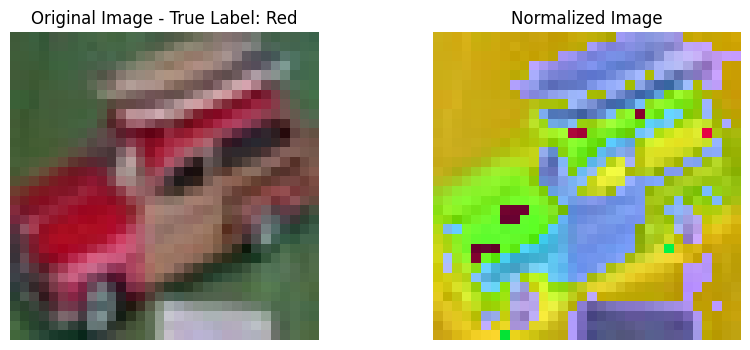

Top 3 Predicted Labels with Confidence Percentages:
1: Label = Red, Confidence = 99.31%
2: Label = Brown, Confidence = 0.47%
3: Label = Orange, Confidence = 0.10%


In [32]:
# Set the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a random image and label from the test dataset using the ColorDataset_RGB
random_index = random.randint(0, len(test_dataset_rgb) - 1)
image_normalized, label = test_dataset_rgb[random_index]

# Prepare the image for inference
image_tensor = image_normalized.unsqueeze(0).to(device)  # Add batch dimension and send to device

# Run the model to get the output logits
with torch.no_grad():
    output = model(image_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    top3_prob, top3_labels = torch.topk(probabilities, 3)

# Convert probabilities and labels to CPU for displaying
top3_prob = top3_prob.cpu().numpy().flatten()
top3_labels = top3_labels.cpu().numpy().flatten()

# Visualize the results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Original image (pre normalization)
# Load the image from the file path for visualization
image_path = x_test[random_index]
original_img = np.array(Image.open(image_path).convert('RGB'))
axs[0].imshow(original_img)
axs[0].set_title(f'Original Image - True Label: {labels[label]}')
axs[0].axis('off')

# Normalized image (post normalization)
# Rescale the normalized image for visualization
normalized_img = (original_img - mean_rgb / std_dev_rgb) * 255
normalized_img = normalized_img.astype(np.uint8)
axs[1].imshow(normalized_img)
axs[1].set_title('Normalized Image')
axs[1].axis('off')

plt.show()

# Print the predicted labels with confidence percentages
print("Top 3 Predicted Labels with Confidence Percentages:")
for i, idx in enumerate(top3_labels):
    print(f"{i+1}: Label = {labels[idx]}, Confidence = {top3_prob[i]*100:.2f}%")